## Einstein Omics Workshop: Ancestry Analysis Tutorial 
**Author**: David Yang<br>
**Laboratory**: Sri Raj and John Greally<br>
**Date**: February 2024

***
<div class="alert alert-block alert-warning">
<b>README:</b> 
Select Kernel: "conda env:omics-workshop-python". It is crucial for the tutorial's execution that all associated scripts are located in the same directory. 
To successfully complete the tutorial, execute all commands in sequence.  For more information about the files needed, please refer to the README.
    
</div>
<div class="alert alert-block alert-warning">
<b>Note:</b> There are two versions of PLINK (1.9 or 2), depending on the function we will be using one or the other.
    The "!" is a command that allows to run a command line package on Jupyter
</div>

***

### Ancestry Analysis Tutorial
Analysis of population structure is a pre-requisite for association studies between human genetic variants and phenotypes (ex: [(Genome Wide Association Study (GWAS) for Type 2 Diabetes)](https://www.nature.com/articles/s41597-020-00716-7) to control for genetic differences from ancestry. This vignette will cover principal components analysis (PCA) and admixture analysis, which are techniques used by population geneticists to understand patterns of genetic variation seen across human populations. We will start by preparing our datasets using multiple quality control thresholds, then we will run the analyses and vizualize the results generated along the way.

**Outline:** <br>
    1) Prepare the query dataset: Single nucleotide polymorphisms (SNPs) from the International HapMap Project. <br>
    2) Prepare the reference dataset: SNPs from the 1000 Genomes Project.<br>
    3) Merge the query and reference SNPs.<br>
    4) Principal Components Analysis.<br>
    5) Admixture Analysis. (💡 Not in this vignette)<br>

#### Background

Population geneticists study the genetic variation within and between populations and the evolutionary forces that shape this variation. One aspect of this research is the analysis of population structure or stratification (PS) – the distribution and composition of genetic variation among populations. This is mainly identified by differences in allele frequencies between two subpopulations. PS of human populations is shaped by many evolutionary processes: non-random mating, geographic isolation of subpopulations with low rates of migration, gene flow over many generations, bottleneck events.

When analyzing human genomic datasets, PS differences between case and control datasets can confound association studies seeking to associate genetic variants with specific traits or diseases. For example, if cases come from one population and controls from another, genetic variants associated with a trait may actually explain ancestry differences between the two groups. Correcting for PS using the methods discussed in this tutorial (Principal Components Analysis (PCA)) can be used to ensure that observed associations are not artifacts of underlying population differences in the distribution and composition of genetic variation. By analyzing human genetic data, we can quantify allele frequencies of genetic variants and use a reference dataset to relate these patterns to genetic ancestry.

In populations represented by multiple different continental ancestries, due to admixture that results from migration and gene flow, we can measure the percentage of each continental ancestry represented in an individual, called global ancestry proportions. We will also quantify this admixture. In human populations, admixture can be a consequence of historical events such as migration or gene flow between two populations. Understanding admixture is crucial in genetic association studies, as it can influence the distribution of genetic traits and impact the interpretation of genetic associations Analyzing patterns of admixture can also provide insights into the demographic history, migration patterns, and genetic diversity of populations.

#### An example case of the potential pitfalls of population structure in case-control studies:

"When cases and controls have different allele frequencies attributable to diversity in background population, unrelated to outcome status, a study is said to have population stratification." [(Cardon and Palmer, 2003)](https://pubmed.ncbi.nlm.nih.gov/12598158/)

This [example (Knowler et al., 1988)](https://www.researchgate.net/profile/Robert-Williams-52/publication/19979684_Gm351314_and_type_2_diabetes_mellitus_An_association_in_American_Indians_with_genetic_admixture/links/5b14966e4585150a0a669330/Gm35-13-14-and-type-2-diabetes-mellitus-An-association-in-American-Indians-with-genetic-admixture.pdf) highlights how PS can lead to spurious associations when genetic ancestry is linked with both the disease/trait and the genetic marker under scrutiny. In this logintudinal study of type 2 diabetes in 4,920 Native Americans of the Pima and Papago tribes, the authors demonstrate how an inverse association between the Gm3;5,13,14 haplotype and a type 2 diabetes mellitus (T2D) (prevalence ratio = 0.27, 95% CI=0.18-0.40) can be found when NOT accounting for genetic ancestry. This would lead to the false conclusion that the haplotype acts to or is closely linked to a locus that decreases the risk for T2D. However, when accounting accounting for ancestry (by self-reported ancestry and family records) this association was not seen.

- The Gm3;5,13,14 haplotype haplotype has a very low frequency among full-heritage Pima and Papago Indians (0.006 in each group), but a high frequency in Caucasian Europeans (0.665).
- T2D is more prevalent in Native Americans (~40%) than in Europeans (~15%).).
- The inverse association between the Gm3;5,13,14 haplotype and T2DM is attributable to ancestral population of origin rather than to
linkage disequilibrium between the disease and marker loci.
-  The Gm3;5,13,14 haplotype serves as a marker of admixture between Native Americans and Europeans.


Learn more here: [Assessing the impact of population stratification on genetic association studies](https://www.nature.com/articles/ng1333)

### Quality Control using PLINK Software
***
This tutorial has been adapted from Andries T. Marees [(github)](https://github.com/MareesAT/GWA_tutorial/)
***
In this tutorial, we will be conducting our genetic analysis using a software called PLINK. *Genetic ancestry analysis* involves a comprehensive quality control (QC) process to ensure the accuracy and reliability of results. QC is essential for identifying and mitigating potential issues arising from genotyping errors, sample contamination, and other data anomalies. [PLINK](https://www.cog-genomics.org/plink/1.9/) provides a robust set of tools to assess and process genetic data.

The dataset used in this tutorial was generated using publicly available data from the International HapMap Project (hapmap3_r3_b36_fwd.consensus.qc.). The data is stored in [PLINK binary format](https://www.cog-genomics.org/plink/1.9/input#bed) which is composed of three files with the same name, but different extention (*.fam, *.bed, *.bim). 

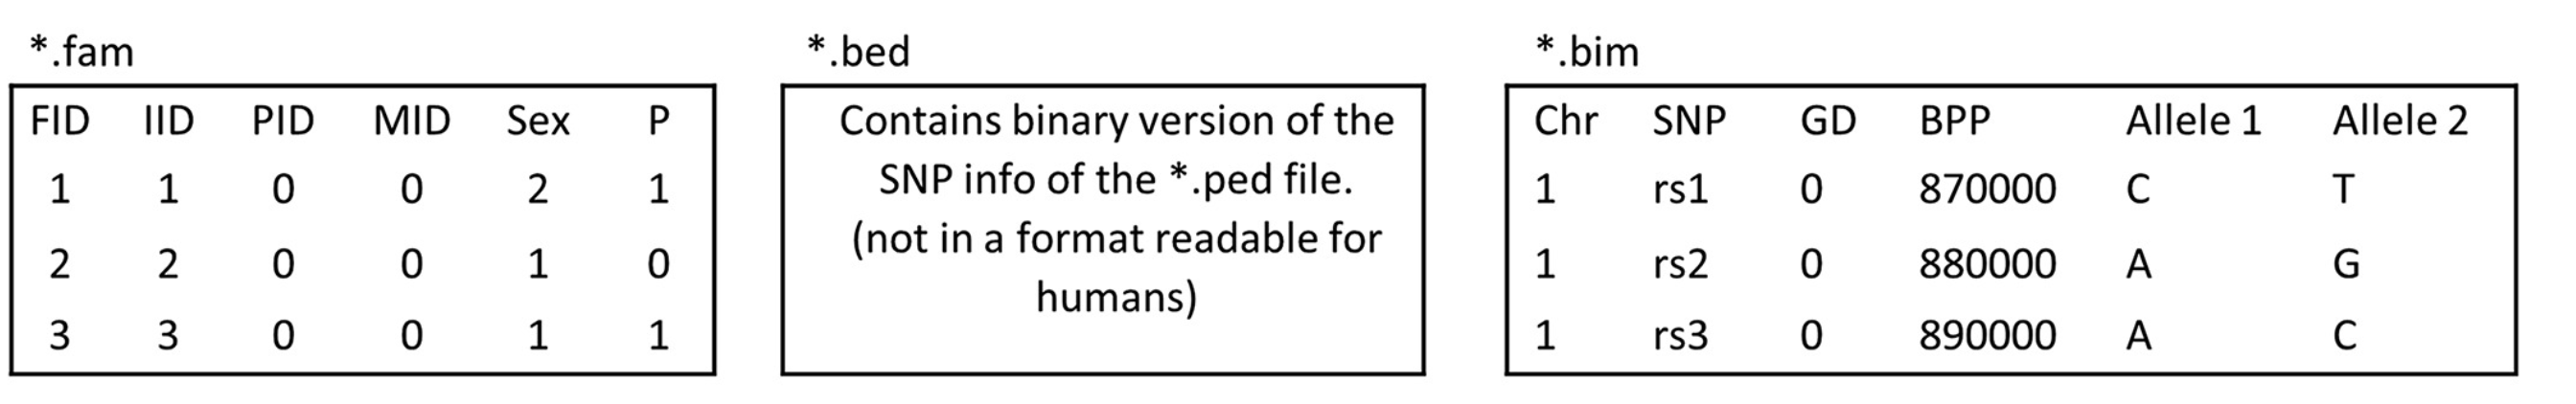

- *.fam: contains individual's and familyinformation
- *.bed: contains the individual's genotypes
- *.bim: contains the genetic variant infomation (ex. chr, position, Ref/Alt alleles)


Phenotypic information for these samples was simulated for a simulated binary outcome measure, representing a binary phenotypic trait. The simulated outcome measure was exclusively applied to the founders in the HapMap data (file name:HapMap_3_r3_1). The QC steps covered in this next section will work through a number of QC steps to comprehensively process genetic data for downstream applications such as genome wide association studies (GWAS) or population structure analysis.

Most GWAS studies focus on ethnically homogenous populations, excluding population outliers. The HapMap data used in this tutorial encompasses multiple distinct ethnic groups, posing challenges for analysis. Therefore, we have specifically chosen only the EUR (European) individuals from the entire HapMap sample for the first part of this tutorial. 


For a comprehensive theoretical understanding of all QC (Quality Control) steps, we recommend referring to the accompanying article: [A tutorial on conducting Genome-Wide-Association Studies: Quality control and statistical analysis](https://www.ncbi.nlm.nih.gov/pubmed/29484742).

**Key QC steps that will be covered:** 

1) Evaluate individual and SNP missingness
2) Identify inconsistencies in reported vs. genetic sex of subjects  
3) Filter by minor allele frequency (MAF) 
4) Identify deviations from Hardy–Weinberg equilibrium (HWE) 
5) Calulcate heterozygosity rate 
6) Identify related samples
7) Identify outliers 

### Step 1: Let's start by taking a look at the contents of our dataset using [PLINK](https://www.cog-genomics.org/plink/1.9/).


In [ ]:
!mkdir results

In [47]:
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --freq -out results/HapMap_3_r3_1.freq --memory 120000

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_1.freq.log.
Options in effect:
  --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1
  --freq
  --memory 120000
  --out results/HapMap_3_r3_1.freq

11794 MB RAM detected; reserving 120000 MB for main workspace.
Allocated 6756 MB successfully, after larger attempt(s) failed.


1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
); many commands treat these as missing.
Total genotyping rate is 0.997378.
--freq: Allele frequencies (founders only) written to
results/HapMap_3_r3_1.freq.frq .


<code style="background:yellow;color:black">Understanding PLINK output</code>


1. `1457897 variants loaded from .bim file.`: Indicates that PLINK has loaded 1,457,897 genetic variants (SNPs, indels, etc.) from the .bim file, which typically contains information about the markers in a genetic dataset.

2. `165 people (80 males, 85 females) loaded from .fam.`: PLINK has loaded data on 165 individuals from the .fam file, which usually contains information about individuals in a genetic dataset. Here, it shows that there are 80 males and 85 females.

3. `112 phenotype values loaded from .fam.`: Indicates that PLINK has loaded phenotype values for 112 individuals from the .fam file. Phenotype values could represent various traits, conditions, or characteristics for each individual.

4. `Using 1 thread (no multithreaded calculations invoked).`: PLINK is configured to use a single thread for calculations. PLINK can be parallelized to speed up computations, but in this case, it's running in single-threaded mode.

5. `Before main variant filters, 112 founders and 53 nonfounders present.`: Shows the number of founders (individuals with known parents) and non-founders (individuals without known parents) in the dataset.
- Number of Founders (112): These are individuals who are considered the starting point of their respective family trees within the dataset.
- Number of Non-founders (53): These are individuals who have parents present in the dataset.

6. `Warning: 225 het. haploid genotypes present (see HapMap_3_r3_1.freq.hh ); many commands treat these as missing.`: Indicates a warning that 225 heterozygous haploid genotypes are present. Some PLINK commands might treat these as missing data.

7. `Total genotyping rate is 0.997378.`: Shows the overall genotyping rate, indicating the proportion of successfully genotyped markers across all individuals.

8. `--freq: Allele frequencies (founders only) written to HapMap_3_r3_1.freq.frq .`: Informs that PLINK has written allele frequencies (for founders only) to the specified output file, HapMap_3_r3_1.freq.frq.

Let's move onto processing the data using PLINK's quality control filters.

### Step 2: Investigate missingness per individual and per SNP and make histograms.
The initial step in all data analysis is to exclude individuals and SNPs with too much missing genotype data. 

- Input: HapMap_3_r3_1
- Output: plink.imiss and plink.lmiss, these files show respectively the proportion of missing SNPs per individual and the proportion of missing individuals per SNP.


In [3]:
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --missing --out results/HapMap

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap.log.
Options in effect:
  --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1
  --missing
  --out results/HapMap

11794 MB RAM detected; reserving 5897 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
commands treat these as missing.
Total genotyping rate is 0.997378.
--missing: Sample missing dat

Most samples and SNPs have a very low missingness rate!

#### 2.1 Remove SNPs and individuals with high levels of missingness
These steps will remove individuals from our dataset that have low genotype calls.
There are 2 filters that can be applied:
- --geno -> filter SNPs with low genotype calls.
- --mind -> filter individuals with low genotype calls.

 *SNP filtering should be performed before individual filtering.

In [4]:
# Remove individuals with missingness >0.2. (No one should be removed, we are using a very relaxed threshold of genotype missingness in this first example)
# To include only SNPs with a 80% genotyping rate (20% missing) use
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --geno 0.2 --make-bed --out results/HapMap_3_r3_2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_2.log.
Options in effect:
  --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1
  --geno 0.2
  --make-bed
  --out results/HapMap_3_r3_2

11794 MB RAM detected; reserving 5897 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.9973

In [5]:
# Remove individuals with missingness >0.2.
# exclude with more than 20% missing genotype
!plink --bfile results/HapMap_3_r3_2 --mind 0.2 --make-bed --out results/HapMap_3_r3_3

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_3.log.
Options in effect:
  --bfile results/HapMap_3_r3_2
  --make-bed
  --mind 0.2
  --out results/HapMap_3_r3_3

11794 MB RAM detected; reserving 5897 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.997378.
1457897 variants and 165 peop

In [6]:
# Remove SNPs with missingness >0.02.
!plink --bfile results/HapMap_3_r3_3 --geno 0.02 --make-bed --out results/HapMap_3_r3_4

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_4.log.
Options in effect:
  --bfile results/HapMap_3_r3_3
  --geno 0.02
  --make-bed
  --out results/HapMap_3_r3_4

11794 MB RAM detected; reserving 5897 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.997378.
27454 variants removed due to missing genotype data (--geno).
1430443 variants and 1

In [7]:
# Remove individuals with missingness >0.02.
!plink --bfile results/HapMap_3_r3_4 --mind 0.02 --make-bed --out results/HapMap_3_r3_5

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_5.log.
Options in effect:
  --bfile results/HapMap_3_r3_4
  --make-bed
  --mind 0.02
  --out results/HapMap_3_r3_5

11794 MB RAM detected; reserving 5897 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.997899.
1430443 variants and 165 peo

### Step 3: Identify inconsistencies in reported vs. genetic sex of subjects  

Subjects who were a priori determined as females should have a F value of <0.2, and subjects who were a priori determined as males must have a F value >0.8. This F value is based on the X chromosome homozygosity estimate.
Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.



In [8]:
# Check for sex discrepancy
!plink --bfile results/HapMap_3_r3_5 --check-sex --out results/sex_check

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/sex_check.log.
Options in effect:
  --bfile results/HapMap_3_r3_5
  --check-sex
  --out results/sex_check

11794 MB RAM detected; reserving 5897 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
commands treat these as missing.
Total genotyping rate is 0.997899.
1430443 variants and 165 people pass filters and QC.
Among remaining phenotypes, 56 are cases and 56 are contr

These checks indicate that there is one woman with a sex discrepancy, F=0.99. The following command can be used to deal with individuals with a sex discrepancy.


In [9]:
# This command generates a list of individuals with the "PROBLEM" status
!grep "PROBLEM" results/sex_check.sexcheck| awk '{print$1,$2}'> txt_files/sex_discrepancy.txt

# This command removes the list of individuals with the status
!plink --bfile results/HapMap_3_r3_5 --remove txt_files/sex_discrepancy.txt --make-bed --out results/HapMap_3_r3_6 


PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_6.log.
Options in effect:
  --bfile results/HapMap_3_r3_5
  --make-bed
  --out results/HapMap_3_r3_6
  --remove txt_files/sex_discrepancy.txt

11794 MB RAM detected; reserving 5897 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
--remove: 164 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate in remaining samples is 0.99798.
14304

### Step 4: Filter by MAF


In [10]:
# Generate a bfile with autosomal SNPs only and delete SNPs with a low minor allele frequency (MAF).
# Select autosomal SNPs only (i.e., from chromosomes 1 to 22).
!awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' results/HapMap_3_r3_6.bim > txt_files/snp_1_22.txt
!plink --bfile results/HapMap_3_r3_6 --extract txt_files/snp_1_22.txt --make-bed --out results/HapMap_3_r3_7

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_7.log.
Options in effect:
  --bfile results/HapMap_3_r3_6
  --extract txt_files/snp_1_22.txt
  --make-bed
  --out results/HapMap_3_r3_7

11794 MB RAM detected; reserving 5897 MB for main workspace.
1430443 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--extract: 1398544 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
1398544 variants and 164 people pass filters and QC.
Among rem

In [11]:
# Generate a plot of the MAF distribution.
!plink --bfile results/HapMap_3_r3_7 --freq --out MAF_check

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MAF_check.log.
Options in effect:
  --bfile results/HapMap_3_r3_7
  --freq
  --out MAF_check

11794 MB RAM detected; reserving 5897 MB for main workspace.
1398544 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
--freq: Allele frequencies (founders only) written to MAF_check.frq .


#### 4.1 Visualize the Minor Allele Frequencies 


/gs/gsfs0/shared-lab/raj-lab/David/OmicsWorkshop/04_AncestryAnalysis_SriDavid/1_QC_PCA/MAF_check.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


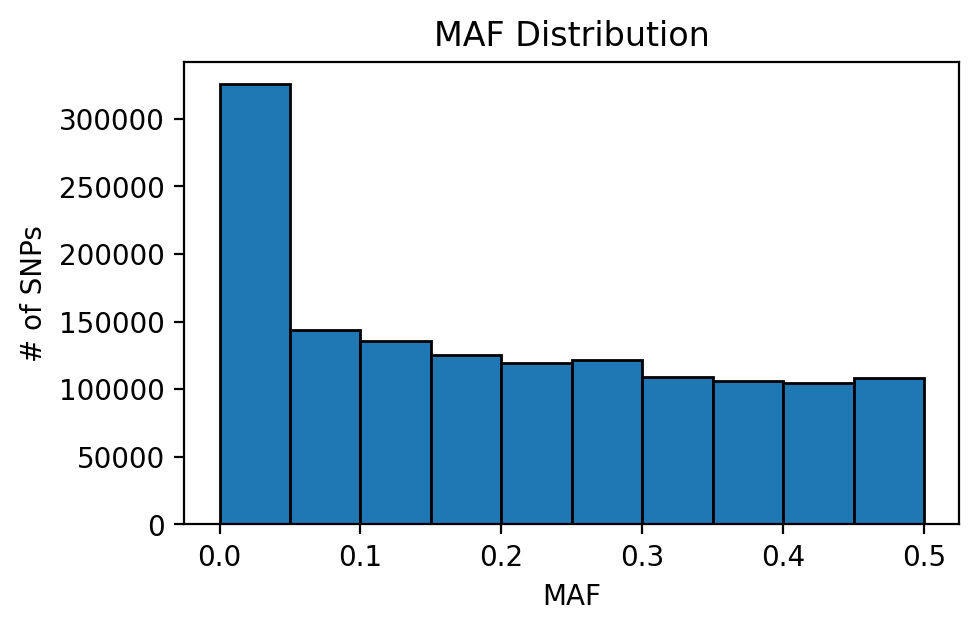

In [12]:
%run MAF_check.py

#### 4.2 Remove SNPs with a low MAF frequency.

In [13]:
!plink --bfile results/HapMap_3_r3_7 --maf 0.05 --make-bed --out results/HapMap_3_r3_8 --memory 120000
# 1073226 SNPs are left
# A conventional MAF threshold for a regular GWAS is between 0.01 or 0.05, depending on sample size.

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_8.log.
Options in effect:
  --bfile results/HapMap_3_r3_7
  --maf 0.05
  --make-bed
  --memory 120000
  --out results/HapMap_3_r3_8

11794 MB RAM detected; reserving 120000 MB for main workspace.
Allocated 6756 MB successfully, after larger attempt(s) failed.
1398544 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
325318 variants removed due to minor al

### Step 5: Identify deviations from Hardy–Weinberg equilibrium (HWE) 


#### 5.1 Visualize Hardy–Weinberg equilibrium (HWE) distribution

In [14]:
# Check the distribution of HWE p-values of all SNPs.
! plink --bfile results/HapMap_3_r3_8 --hardy

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile results/HapMap_3_r3_8
  --hardy

11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hardy: Writing Hardy-Weinberg report (founders only) to plink.hwe ... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656

In [15]:
# Select SNPs with HWE p-value below 0.00001, required for one of the two plots generated by the next script, allows to zoom in on strongly deviating SNPs. 
!awk '{ if ($9 <0.00001) print $0 }' plink.hwe>plinkzoomhwe.hwe

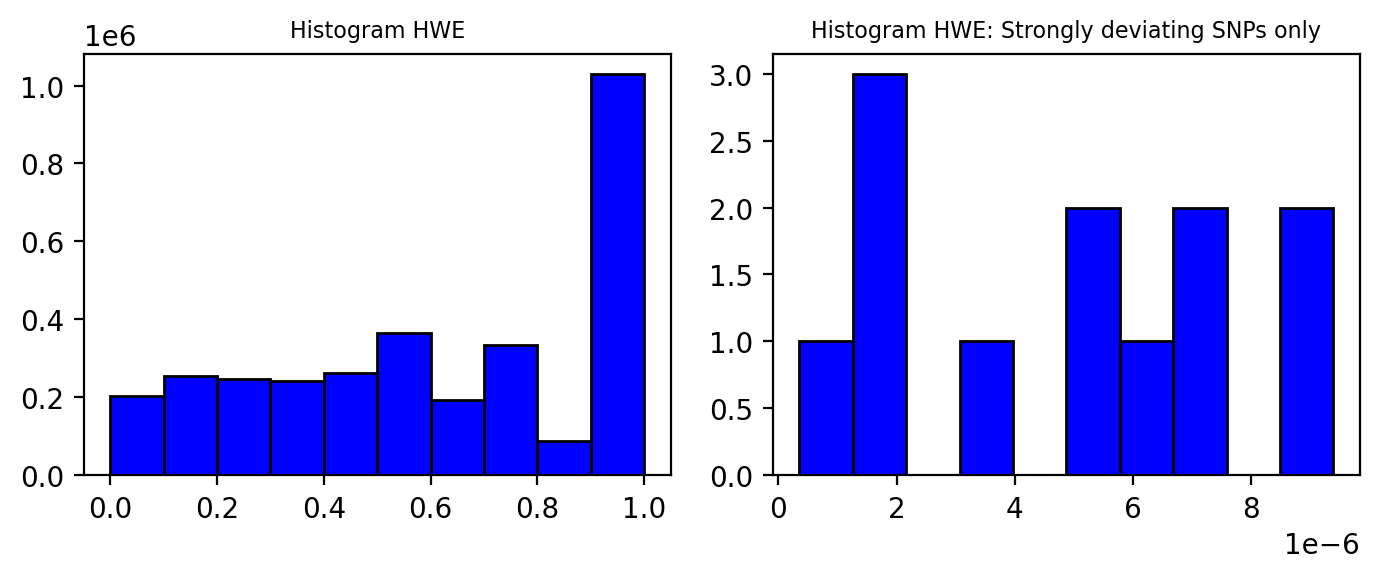

In [16]:
%run HWE.py

#### 5.2 Remove SNPs which are not in Hardy-Weinberg equilibrium (HWE).


In [17]:
# By default the --hwe option in plink only filters for controls.
# Therefore, we use two steps, first we use a stringent HWE threshold for controls, followed by a less stringent threshold for the case data.
!plink --bfile results/HapMap_3_r3_8 --hwe 1e-6 --make-bed --out results/HapMap_hwe_filter_step1

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_hwe_filter_step1.log.
Options in effect:
  --bfile results/HapMap_3_r3_8
  --hwe 1e-6
  --make-bed
  --out results/HapMap_hwe_filter_step1

11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hardy-Weinberg exact test.
1073226 variants and 164 people pass filter

In [18]:
# The HWE threshold for the cases filters out only SNPs which deviate extremely from HWE. 
# This second HWE step only focusses on cases because in the controls all SNPs with a HWE p-value < hwe 1e-6 were already removed
!plink --bfile results/HapMap_hwe_filter_step1 --hwe 1e-10 --hwe-all --make-bed --out results/HapMap_3_r3_9

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_9.log.
Options in effect:
  --bfile results/HapMap_hwe_filter_step1
  --hwe 1e-10
  --hwe-all
  --make-bed
  --out results/HapMap_3_r3_9

Note: --hwe-all flag deprecated.  Use "--hwe include-nonctrl".
11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hard

### Step 6: Calculate heterozygosity rate 


In [19]:
# Generate a plot of the distribution of the heterozygosity rate and remove individuals with a heterozygosity rate deviating more than 3 standard deviations from the mean.
# Check for heterozygosity are performed on a set of SNPs which are not highly correlated.
# Therefore, to generate a list of non-(highly)correlated SNPs, we exclude high inversion regions (inversion.txt [High LD regions]) and prune the SNPs using the command --indep-pairwise�.
# The parameters "50 5 0.2" stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.

!plink --bfile results/HapMap_3_r3_9 --exclude txt_files/inversion.txt --range --indep-pairwise 50 5 0.2 --out results/indepSNP

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/indepSNP.log.
Options in effect:
  --bfile results/HapMap_3_r3_9
  --exclude txt_files/inversion.txt
  --indep-pairwise 50 5 0.2
  --out results/indepSNP
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--exclude range: 9893 variants excluded.
--exclude range: 1063333 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838

In [20]:
#This file contains your pruned data set.
!plink --bfile results/HapMap_3_r3_9 --extract results/indepSNP.prune.in --het --out results/het_check

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/het_check.log.
Options in effect:
  --bfile results/HapMap_3_r3_9
  --extract results/indepSNP.prune.in
  --het
  --out results/het_check

11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--extract: 104144 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998028.
104144 variants and 164 people pass filters and QC.
Among remaining pheno

In [21]:
# The following code generates a list of individuals who deviate more than 3 standard deviations from the heterozygosity rate mean.
%run heterozygosity_outliers_list

      FID      IID   O(HOM)     E(HOM)     N(NM)        F  HET_RATE   HET_DST
81   1330  NA12342  68049.0  6.724e+04  103571.0  0.02229  0.342972 -3.667119
106  1459  NA12874  68802.0  6.756e+04  104068.0   0.0339  0.338875 -5.048399


#### 6.1 Remove individuals with high heterozygosity rate

In [22]:
# Output of the command above: fail-het-qc.txt 
# When using our example data, this list contains 2 individuals (i.e., two individuals have a heterozygosity rate deviating more than 3 SD's from the mean).
# Adapt this file to make it compatible for PLINK, by removing all quotation marks from the file and selecting only the first two columns.
!sed 's/"// g' txt_files/fail-het-qc.txt | awk '{print$1, $2}'> txt_files/het_fail_ind.txt

# Remove heterozygosity rate outliers.
!plink --bfile results/HapMap_3_r3_9 --remove txt_files/het_fail_ind.txt --make-bed --out results/HapMap_3_r3_10


PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_10.log.
Options in effect:
  --bfile results/HapMap_3_r3_9
  --make-bed
  --out results/HapMap_3_r3_10
  --remove txt_files/het_fail_ind.txt

11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--remove: 162 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 110 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.998063.
1073226 variants and 162 people pass filter

### Step 7: Identify related samples

It is essential to check datasets you analyse for cryptic relatedness.
A conventional GWAS assumes that all subjects are unrelated (i.e., no pair of individuals is more closely related than second‐degree relatives). Without appropriate correction, the inclusion of relatives could lead to biased estimations of standard errors of SNP effect sizes. 

We will use PLINK's [KING](https://pubmed.ncbi.nlm.nih.gov/20926424/) (Kinship-based INference for GWAS) analysis to estimate pairwise kinship coefficients between individuals in the dataset.PLINK's KING analysis calculates pairwise kinship coefficients between individuals based on their genetic similarity across a set of markers.
The resulting kinship coefficients are then often used to identify related individuals or to assess the level of relatedness within the dataset.

Thresholds are applied to categorize the kinship coefficients into different relatedness categories. Commonly used thresholds include:

<table>
<thead>
<tr><th>KING Coeff</th><th>Meaning</th></tr>
</thead>
<tbody>
<tr><td>0.25</td><td>Identifies first-degree relatives (parent-offspring, full siblings).</td></tr>
<tr><td>0.125</td><td>Identifies second-degree relatives (half-siblings, grandparent-grandchild).</td></tr>
<tr><td>0.5</td><td>KING kinship coefficients are scaled such that duplicate samples have kinship 0.5, not 1.</td></tr>
</tbody>
</table>


For this tutorial, we will use a threshold of 0.125 to remove individuals that are related to the 2nd degree.


In [23]:
!plink2 --bfile results/HapMap_3_r3_10 --king-cutoff 0.125 --out results/king_calc


PLINK v2.00a5LM 64-bit Intel (23 Sep 2023)     www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/king_calc.log.
Options in effect:
  --bfile results/HapMap_3_r3_10
  --king-cutoff 0.125
  --out results/king_calc

Start time: Mon Mar  4 17:50:19 2024
11794 MiB RAM detected, ~6807 available; reserving 5897 MiB for main workspace.
Using up to 4 compute threads.
162 samples (84 females, 78 males; 110 founders) loaded from
results/HapMap_3_r3_10.fam.
1073226 variants loaded from results/HapMap_3_r3_10.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--king-cutoff pass 1/1: Scanning for rare variants... 121824303642485461677379859197done.
0 variants handled by initial scan (1073226 remaining).
--king-cutoff pass 1/1: Condensing...               done.
--king-cutoff: 1073226 variants processed.
--king-cutoff: Excluded sample IDs written to
results/king_calc.king.cutoff.out.id , and 110 remaining sample IDs w

In [24]:
!plink2 --bfile results/HapMap_3_r3_10 --keep results/king_calc.king.cutoff.in.id --make-bed --out results/HapMap_3_r3_11
# 110 samples remain

PLINK v2.00a5LM 64-bit Intel (23 Sep 2023)     www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_3_r3_11.log.
Options in effect:
  --bfile results/HapMap_3_r3_10
  --keep results/king_calc.king.cutoff.in.id
  --make-bed
  --out results/HapMap_3_r3_11

Start time: Mon Mar  4 17:50:20 2024
11794 MiB RAM detected, ~6804 available; reserving 5897 MiB for main workspace.
Using up to 4 compute threads.
162 samples (84 females, 78 males; 110 founders) loaded from
results/HapMap_3_r3_10.fam.
1073226 variants loaded from results/HapMap_3_r3_10.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--keep: 110 samples remaining.
110 samples (56 females, 54 males; 105 founders) remaining after main filters.
54 cases and 51 controls remaining after main filters.
Writing results/HapMap_3_r3_11.fam ... done.
Writing results/HapMap_3_r3_11.bim ... done.
Writing results/HapMap_3_r3_11.bed ... 1218243036424854616773

### <code style="background:yellow;color:black">CONGRATULATIONS</code>

**You've just succesfully completed the first part of tutorial! You are now able to conduct a proper genetic QC.** 

We will use these QC'ed samples for ancestry analysis in the next section.
This will require 2 datasets:
1) Our QC'ed HapMap samples
2) Genetic data of 629 individuals from different ethnic backgrounds from the 1000 Genomes Project 

The 1000 Genomes Project was downloaded using 

```bash
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz
```

The first portion of this analysis requires pre-processing the data so that variant IDs are consistent, both datasets have the same variants, and merging the 2 datasets together.

### Step 8: Population Stratification via PCA

We are using the 1000 Genomes dataset as a reference panel of genetic variation to analyze the ancestry of our HapMap samples. To get started, we will process the 1000 Genomes data as we did previously.

* The QC'ed file can be generated running the commands in proccess.txt, or you can proceed to merging the dataset. The QC'ed reference panel is provided already.


#### 8.1 Perform QC the 1000 Genomes data

In [25]:
# For good practice, we will assign unique indentifiers to the SNPs with a missing rs-identifier (i.e., the SNPs with ".").
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/ALL.2of4intersection.20100804.genotypes \
--set-missing-var-ids @:#[b37]\$1,\$2 \
--make-bed \
--out results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs 

!plink --allow-no-sex --bfile results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs --geno 0.2 --make-bed --out results/1kG_PCA 
!plink --bfile results/1kG_PCA --mind 0.2 --allow-no-sex --make-bed --out results/1kG_PCA2
!plink --bfile results/1kG_PCA2 --geno 0.02 --allow-no-sex --make-bed --out results/1kG_PCA3
!plink --bfile results/1kG_PCA3 --mind 0.02 --allow-no-sex --make-bed --out results/1kG_PCA4
!plink --bfile results/1kG_PCA4 --maf 0.05 --allow-no-sex --make-bed --out results/1kG_PCA5

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs.log.
Options in effect:
  --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/ALL.2of4intersection.20100804.genotypes
  --make-bed
  --out results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs
  --set-missing-var-ids @:#[b37]1,2

11794 MB RAM detected; reserving 5897 MB for main workspace.
25488488 variants loaded from .bim file.
10375501 missing IDs set.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021

#### 8.2 Make sure both datasets contain the same genetic variants

In [26]:
# Extract the variants present in HapMap dataset from the 1000 genomes dataset.
# We are doing this so that both datasets contain the same variants, which is neccesary for running PCA.
!awk '{print$2}' results/HapMap_3_r3_11.bim > txt_files/HapMap_SNPs.txt
!plink --bfile results/1kG_PCA5 --extract txt_files/HapMap_SNPs.txt --make-bed --out results/1kG_PCA6



PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/1kG_PCA6.log.
Options in effect:
  --bfile results/1kG_PCA5
  --extract txt_files/HapMap_SNPs.txt
  --make-bed
  --out results/1kG_PCA6

11794 MB RAM detected; reserving 5897 MB for main workspace.
5808310 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/1kG_PCA6.nosex .
--extract: 1000993 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999411.
1000993 variants and 629 people pass filters an

In [27]:
# Extract the variants present in 1000 Genomes dataset from the HapMap dataset.
!awk '{print$2}' results/1kG_PCA6.bim > txt_files/1kG_PCA6_SNPs.txt
!plink --bfile results/HapMap_3_r3_11 --extract txt_files/1kG_PCA6_SNPs.txt --recode --make-bed --out results/HapMap_PCA
# The datasets now contain the exact same variants.

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_PCA.log.
Options in effect:
  --bfile results/HapMap_3_r3_11
  --extract txt_files/1kG_PCA6_SNPs.txt
  --make-bed
  --out results/HapMap_PCA
  --recode

11794 MB RAM detected; reserving 5897 MB for main workspace.
1073226 variants loaded from .bim file.
110 people (54 males, 56 females) loaded from .fam.
105 phenotype values loaded from .fam.
--extract: 1000993 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 105 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998016.
1000993 variants and 110 people pass filters and QC.

#### 8.3 Make sure both datasets are aligned to the same reference genome guild

In [28]:
# The datasets must have the same build. Change the build 1000 Genomes data build.
!awk '{print$2,$4}' results/HapMap_PCA.map > txt_files/buildhapmap.txt
# buildhapmap.txt contains one SNP-id and physical position per line.

!plink --bfile results/1kG_PCA6 --update-map txt_files/buildhapmap.txt --make-bed --out results/1kG_PCA7
# 1kG_PCA7 and HapMap_PCA now have the same build

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/1kG_PCA7.log.
Options in effect:
  --bfile results/1kG_PCA6
  --make-bed
  --out results/1kG_PCA7
  --update-map txt_files/buildhapmap.txt

11794 MB RAM detected; reserving 5897 MB for main workspace.
1000993 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/1kG_PCA7.nosex .
--update-map: 1000993 values updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999411.
1000993 variants and 629 people pass filters 

#### 8.4 Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable, for this we conduct 3 steps:
1) Make sure the reference genome is similar in the HapMap and the 1000 Genomes Project datasets.
2) Resolve strand issues.
3) Remove the SNPs which after the previous two steps still differ between datasets.

In [29]:
# 1) set reference genome 
!awk '{print$2,$5}' results/1kG_PCA7.bim > txt_files/1kg_ref-list.txt
!plink --bfile results/HapMap_PCA --reference-allele txt_files/1kg_ref-list.txt --make-bed --out results/HapMap-adj
# The 1kG_PCA7 and the HapMap-adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.


PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap-adj.log.
Options in effect:
  --a1-allele txt_files/1kg_ref-list.txt
  --bfile results/HapMap_PCA
  --make-bed
  --out results/HapMap-adj

11794 MB RAM detected; reserving 5897 MB for main workspace.
1000993 variants loaded from .bim file.
110 people (54 males, 56 females) loaded from .fam.
105 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 105 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998016.
--a1-allele: 1000993 assignments made.
1000993 variants and 110 people pass filters and QC.
Among remaini

In [30]:
# 2) Resolve strand issues.
# Check for potential strand issues.
!awk '{print$2,$5,$6}' results/1kG_PCA7.bim > results/1kGPCA7_tmp
!awk '{print$2,$5,$6}' results/HapMap-adj.bim > results/HapMap-adj_tmp
!sort results/1kGPCA7_tmp results/HapMap-adj_tmp |uniq -u > txt_files/all_differences.txt
!less -S  txt_files/all_differences.txt | wc -l
# 1624 differences between the files, some of these might be due to strand issues.

1624


In [31]:
# Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
!awk '{print$1}' txt_files/all_differences.txt | sort -u > txt_files/flip_list.txt
!less -S txt_files/flip_list.txt | wc -l

812


In [32]:
# Generates a file of 812 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 812 non-corresponding SNPs. 
!plink --bfile results/HapMap-adj --flip txt_files/flip_list.txt --reference-allele txt_files/1kg_ref-list.txt --make-bed --out results/corrected_hapmap

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/corrected_hapmap.log.
Options in effect:
  --a1-allele txt_files/1kg_ref-list.txt
  --bfile results/HapMap-adj
  --flip txt_files/flip_list.txt
  --make-bed
  --out results/corrected_hapmap

11794 MB RAM detected; reserving 5897 MB for main workspace.
1000993 variants loaded from .bim file.
110 people (54 males, 56 females) loaded from .fam.
105 phenotype values loaded from .fam.
--flip: 812 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 105 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998016.
--a1-allele: 1000993 assignments m

In [33]:
# Check for SNPs which are still problematic after they have been flipped.
!awk '{print$2,$5,$6}' results/corrected_hapmap.bim > results/corrected_hapmap_tmp
!sort results/1kGPCA7_tmp results/corrected_hapmap_tmp |uniq -u  > txt_files/uncorresponding_SNPs.txt
! less -S txt_files/uncorresponding_SNPs.txt | wc -l
# This file demonstrates that there are 84 differences between the files.

84


In [34]:
# 3) Remove problematic SNPs from HapMap and 1000 Genomes.
!awk '{print$1}' txt_files/uncorresponding_SNPs.txt | sort -u > txt_files/SNPs_for_exlusion.txt
!less -S txt_files/SNPs_for_exlusion.txt | wc -l
# The command above generates a list of the 42 SNPs which caused the 84 differences between the HapMap and the 1000 Genomes data sets after flipping and setting of the reference genome.

42


In [35]:
# Remove the 42 problematic SNPs from both datasets.
!plink --bfile results/corrected_hapmap --exclude txt_files/SNPs_for_exlusion.txt --make-bed --out results/HapMap_PCA2
!plink --bfile results/1kG_PCA7 --exclude txt_files/SNPs_for_exlusion.txt --make-bed --out results/1kG_PCA8

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/HapMap_PCA2.log.
Options in effect:
  --bfile results/corrected_hapmap
  --exclude txt_files/SNPs_for_exlusion.txt
  --make-bed
  --out results/HapMap_PCA2

11794 MB RAM detected; reserving 5897 MB for main workspace.
1000993 variants loaded from .bim file.
110 people (54 males, 56 females) loaded from .fam.
105 phenotype values loaded from .fam.
--exclude: 1000951 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 105 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998016.
1000951 variants and 110 people pass filters and QC.
Am

#### 8.5 Merge HapMap with 1000 Genomes Data.


In [36]:
# Note, there will be sample overlap between the HapMap and 1000 Genomes datasets. However, for the purpose of this tutorial this is not important.

!plink --bfile results/HapMap_PCA2 --bmerge results/1kG_PCA8.bed results/1kG_PCA8.bim results/1kG_PCA8.fam --allow-no-sex --make-bed --out results/PCA_merge2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/PCA_merge2.log.
Options in effect:
  --allow-no-sex
  --bfile results/HapMap_PCA2
  --bmerge results/1kG_PCA8.bed results/1kG_PCA8.bim results/1kG_PCA8.fam
  --make-bed
  --out results/PCA_merge2

11794 MB RAM detected; reserving 5897 MB for main workspace.
110 people loaded from results/HapMap_PCA2.fam.
629 people to be merged from results/1kG_PCA8.fam.
Of these, 629 are new, while 0 are present in the base dataset.
1000951 markers loaded from results/HapMap_PCA2.bim.
1000951 markers to be merged from results/1kG_PCA8.bim.
Of these, 0 are new, while 1000951 are present in the base dataset.
Performing single-pass merge (739 people, 1000951 variants).
Merged fileset written to results/PCA_merge2-merge.bed +
results/PCA_merge2-merge.bim + results/PCA_merge2-merge.fam .
1000951 variants loaded from .bim file.
739 p

### Step 9: Run PCA

Prior to running PCA, we will prune our SNP panel based on linkage disequilibrium. 
Performing Linkage Disequilibrium (LD) pruning before PCA is a common preprocessing step in genetic analysis. LD pruning helps address issues related to correlated genetic variants, which can impact the results of PCA and other downstream analyses. 

PCA aims to capture the major sources of genetic variation. By removing variants in high LD, LD pruning helps focus on independent sources of variation, making the interpretation of principal components more straightforward, computationally efficient and mitigate confounding effects.



In [37]:
# Use a set of pruned SNPs
!plink --bfile results/PCA_merge2 --indep-pairwise 50 5 0.2 --out results/PCA_merge2_pruned --memory 120000


!plink --bfile results/PCA_merge2 --extract results/PCA_merge2_pruned.prune.in --make-bed --out results/PCA_merge2_pruned --memory 120000

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/PCA_merge2_pruned.log.
Options in effect:
  --bfile results/PCA_merge2
  --indep-pairwise 50 5 0.2
  --memory 120000
  --out results/PCA_merge2_pruned

11794 MB RAM detected; reserving 120000 MB for main workspace.
Allocated 6756 MB successfully, after larger attempt(s) failed.
1000951 variants loaded from .bim file.
739 people (54 males, 56 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/PCA_merge2_pruned.nosex .
105 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 734 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697

In [38]:
!plink --bfile results/PCA_merge2_pruned --pca --out results/PCA_result

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/PCA_result.log.
Options in effect:
  --bfile results/PCA_merge2_pruned
  --out results/PCA_result
  --pca

11794 MB RAM detected; reserving 5897 MB for main workspace.
128291 variants loaded from .bim file.
739 people (54 males, 56 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/PCA_result.nosex .
105 phenotype values loaded from .fam.
Using up to 4 threads (change this with --threads).
Before main variant filters, 734 founders and 5 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99909.
128291 variants and 739 people pass filters and QC.
Among remaining phenotypes,

### Step 10: Plot PCA Results

In [39]:
import warnings
warnings.filterwarnings('ignore')
#libraries used in this python script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from matplotlib.pyplot import figure

In [40]:
#Set the color palette for Seaborn
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

#I will use color blind for this test
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [41]:
# Loading and preprocessing of PCA data
# Load in eigenvec calculated using PCA from Plink
pca_vals = pd.read_table("results/PCA_result.eigenvec", delim_whitespace=True, header=None)
pca_ids = pca_vals[1]
print(pca_ids[1:6])
pca_vals.head(5)

1    NA06989
2    NA12336
3    NA12340
4    NA12341
5    NA12144
Name: 1, dtype: object


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1328,NA06984,0.019885,-0.030748,0.034066,0.018899,-0.021113,-0.200622,0.060810,0.163415,...,-0.123741,0.107321,-0.182177,0.053869,0.157975,0.099402,0.096384,-0.045499,-0.055829,-0.080501
1,1328,NA06989,0.019187,-0.030032,0.061603,0.021717,0.339198,0.018762,0.070790,0.001949,...,-0.031691,-0.010743,0.039136,-0.012760,0.074207,0.038163,-0.060067,0.014488,0.045170,0.119997
2,1330,NA12336,0.019705,-0.030960,0.013979,0.021181,0.010443,0.012771,0.001994,-0.003950,...,-0.000498,0.003042,0.001770,-0.005174,-0.010794,-0.017020,-0.012092,0.012953,-0.000873,-0.003473
3,1330,NA12340,0.019672,-0.031049,0.022200,0.014017,-0.048479,-0.012013,-0.010790,0.033049,...,0.149898,0.019586,0.096787,-0.003115,0.034672,0.057316,-0.041905,-0.072541,0.013482,-0.089558
4,1330,NA12341,0.018712,-0.030930,0.025800,0.005095,-0.057044,0.065911,-0.040937,0.055468,...,-0.045067,-0.140115,-0.028044,0.022508,0.134543,0.124301,0.045477,-0.045027,0.087060,0.147676


In [42]:
# Match sample IDs from pca_vals with metadata file
all_metadata = pd.read_table("txt_files/population_labels.txt", delim_whitespace=True, header=None)

# Set the header row as column names
all_metadata.columns = all_metadata.iloc[0]

# Drop the first row (header row)
all_metadata = all_metadata.drop(0)

# Reset the index
all_metadata = all_metadata.reset_index(drop=True)

# Display the modified DataFrame
all_metadata.head(5)
            

,FID,IID,Population
0,HG00098,HG00098,EUR
1,HG00100,HG00100,EUR
2,HG00106,HG00106,EUR
3,HG00112,HG00112,EUR
4,HG00114,HG00114,EUR


In [43]:
# Extract the column you want to write to the text file
Population_labels = all_metadata['Population']
print(Population_labels[1:10])

# Write the population label data to a text file
with open('txt_files/abels_ind2pop.txt', 'w') as file:
    file.write('\n'.join(Population_labels.astype(str)))

1    EUR
2    EUR
3    EUR
4    EUR
5    EUR
6    EUR
7    EUR
8    EUR
9    EUR
Name: Population, dtype: object


In [44]:
all_metadata = pd.read_table("txt_files/population_labels.txt", delim_whitespace=True, header=0)

# Extract unique population labels and create a list
admixture_list = all_metadata['Population'].unique().tolist()

# Create a dictionary mapping individual IDs to population labels
pop_names = dict(zip(all_metadata['IID'], all_metadata['Population']))

# Display the extracted population labels and the individual-to-population mapping
print("Unique Population Labels:", admixture_list)
print("\nIndividual-to-Population Mapping:")
print(pop_names)

# Export pop_names as a tab-delimited file
with open('txt_files/pop_names.txt', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(pop_names.keys())  # Write the header row directly
    writer.writerows(zip(pop_names.keys(), pop_names.values()))  # Write the data
    
pca_vals.insert(2, 'Population_name', pca_vals[1].map(pop_names))
pca_vals.to_csv("txt_files/pca_eigenvec_pop_labels.csv")

Unique Population Labels: ['EUR', 'ASN', 'AMR', 'AFR', 'OWN']

Individual-to-Population Mapping:
{'HG00098': 'EUR', 'HG00100': 'EUR', 'HG00106': 'EUR', 'HG00112': 'EUR', 'HG00114': 'EUR', 'HG00116': 'EUR', 'HG00117': 'EUR', 'HG00118': 'EUR', 'HG00119': 'EUR', 'HG00120': 'EUR', 'HG00122': 'EUR', 'HG00123': 'EUR', 'HG00124': 'EUR', 'HG00126': 'EUR', 'HG00131': 'EUR', 'HG00141': 'EUR', 'HG00142': 'EUR', 'HG00143': 'EUR', 'HG00144': 'EUR', 'HG00145': 'EUR', 'HG00146': 'EUR', 'HG00147': 'EUR', 'HG00148': 'EUR', 'HG00149': 'EUR', 'HG00150': 'EUR', 'HG00151': 'EUR', 'HG00152': 'EUR', 'HG00153': 'EUR', 'HG00156': 'EUR', 'HG00158': 'EUR', 'HG00159': 'EUR', 'HG00160': 'EUR', 'HG00171': 'EUR', 'HG00173': 'EUR', 'HG00174': 'EUR', 'HG00176': 'EUR', 'HG00177': 'EUR', 'HG00178': 'EUR', 'HG00179': 'EUR', 'HG00180': 'EUR', 'HG00181': 'EUR', 'HG00182': 'EUR', 'HG00183': 'EUR', 'HG00185': 'EUR', 'HG00186': 'EUR', 'HG00187': 'EUR', 'HG00188': 'EUR', 'HG00189': 'EUR', 'HG00190': 'EUR', 'HG00231': 'EUR', 'H

In [45]:
# Rename the columns starting from the third column
pca_vals.columns = ['FID', 'IID', 'Population_name'] + [f'PC{i}' for i in range(1, len(pca_vals.columns)-2)]

# Display the DataFrame with the updated column names
pca_vals.head()

,FID,IID,Population_name,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1328,NA06984,OWN,0.019885,-0.030748,0.034066,0.018899,-0.021113,-0.200622,0.060810,...,-0.123741,0.107321,-0.182177,0.053869,0.157975,0.099402,0.096384,-0.045499,-0.055829,-0.080501
1,1328,NA06989,OWN,0.019187,-0.030032,0.061603,0.021717,0.339198,0.018762,0.070790,...,-0.031691,-0.010743,0.039136,-0.012760,0.074207,0.038163,-0.060067,0.014488,0.045170,0.119997
2,1330,NA12336,OWN,0.019705,-0.030960,0.013979,0.021181,0.010443,0.012771,0.001994,...,-0.000498,0.003042,0.001770,-0.005174,-0.010794,-0.017020,-0.012092,0.012953,-0.000873,-0.003473
3,1330,NA12340,OWN,0.019672,-0.031049,0.022200,0.014017,-0.048479,-0.012013,-0.010790,...,0.149898,0.019586,0.096787,-0.003115,0.034672,0.057316,-0.041905,-0.072541,0.013482,-0.089558
4,1330,NA12341,OWN,0.018712,-0.030930,0.025800,0.005095,-0.057044,0.065911,-0.040937,...,-0.045067,-0.140115,-0.028044,0.022508,0.134543,0.124301,0.045477,-0.045027,0.087060,0.147676


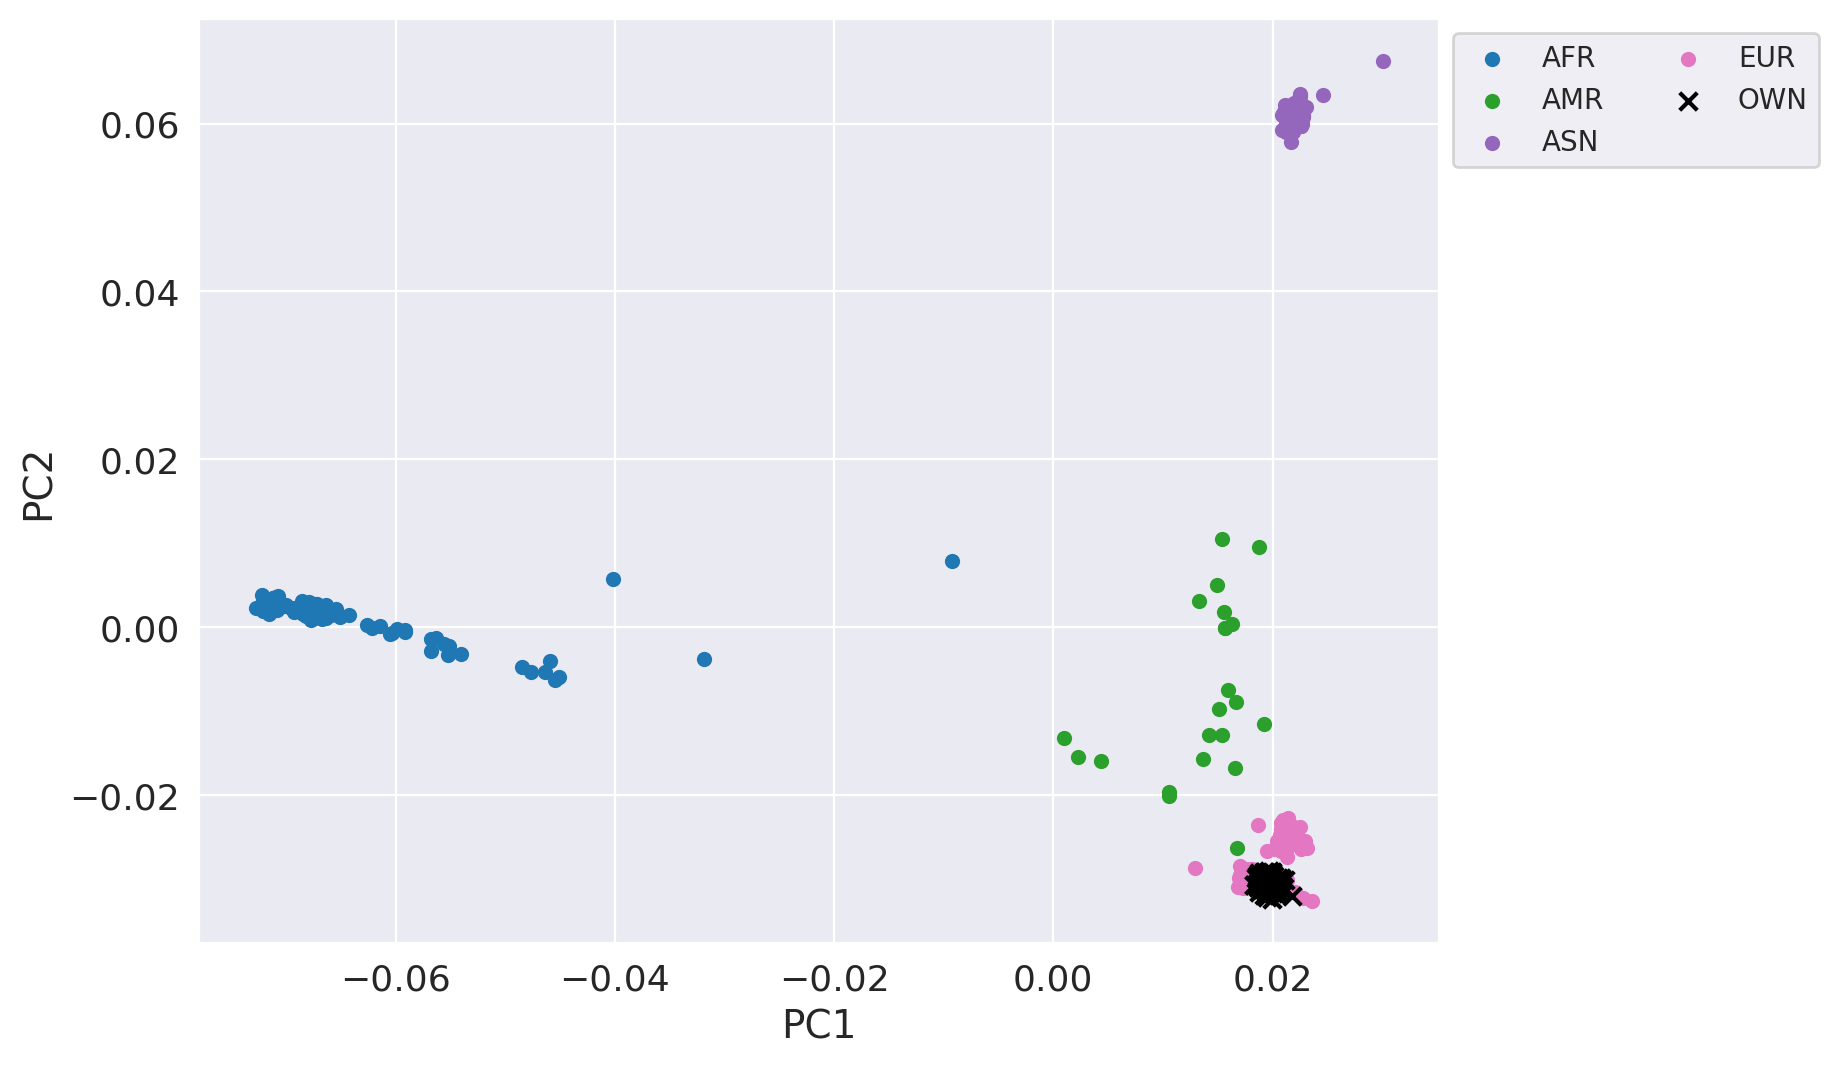

In [46]:
# Choose a color map
cmap = plt.cm.tab20

# Count the number of unique super populations
num_population = pca_vals["Population_name"].nunique()

# Create a color map normalization instance
norm = plt.Normalize(0, num_population)

# Plot PCA grouping by population name
plt.figure(figsize=(8, 6), dpi=200)
groups = pca_vals.groupby("Population_name")

for i, (name, group) in enumerate(groups):
    color = cmap(norm(i))
    if name != "OWN":
        plt.scatter(group["PC1"], group["PC2"], marker="o", label=name, s=20, color=color, zorder=5)
    else:
        plt.scatter(group["PC1"], group["PC2"], marker="x", label=name, s=40, color='black', zorder=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10,} , ncol=2)
plt.savefig('PCA_PC1-PC2.png', bbox_inches="tight")
plt.show()